# Line ratios from saved moment images

In this notebook, I will work with only pre-calculated line maps, which have already been extracted from the cube and have been corrected for the sky problems (at least in theory).  The extraction process is carried out in the 03 series of notebooks.

In [8]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

## Calculate reddening from Balmer decrement

Load the Hα and Hβ maps

In [2]:
imha = Image("../data/ngc346-hi-6563-bin01-sum.fits")

In [3]:
imhb = Image("../data/ngc346-hi-4861-bin01-sum.fits")

And look at the raw ratio:

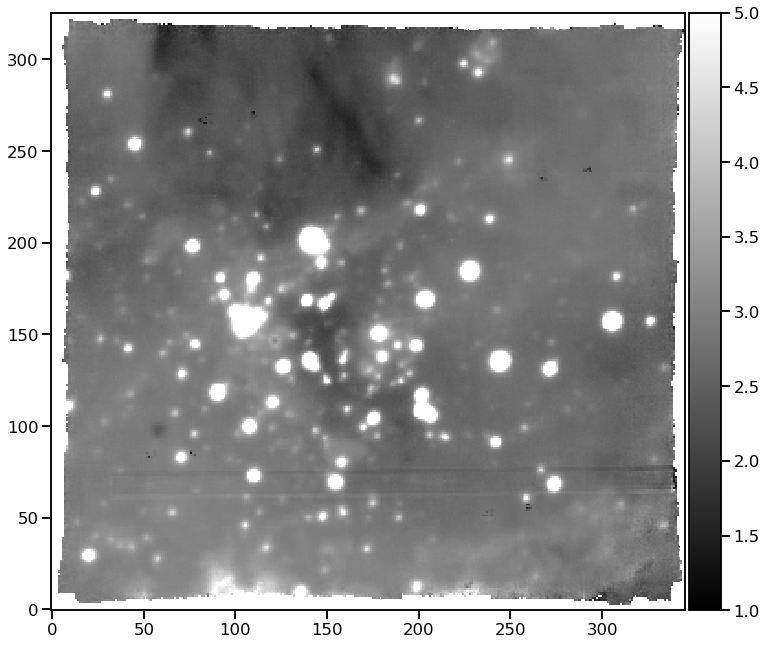

In [7]:
fig, ax = plt.subplots(figsize=(12, 12))
(imha/imhb).plot(vmin=1.0, vmax=5.0, cmap="gray", colorbar="v")

So we see a lot of structure there.  In priniciple, lighter means more extinction.  This seems to be real at the bottom of the image, where we see clear signs of the foreground filament. 

But in other parts, the ratio is suspiciously well correlated with the brightness.  So we need to fix that.

In [19]:
hi = pn.RecAtom("H", 1)

Calculate the theoretical Balmer decrement from PyNeb. Density and temperature from Valerdi:2019a

In [27]:
tem, den = 12500, 100
R0 = hi.getEmissivity(tem, den, wave=6563) / hi.getEmissivity(tem, den, wave=4861)
R0

2.8205128205128207

To make thinks easier, I multiply the Hb values by R0 so we have a square plot.  I zoom in on the faint parts:

In [32]:
imax = 30000
m = imha.data < imax
m = m & (R0*imhb.data < imax)
m = m & ~imha.mask & ~imhb.mask
df = pd.DataFrame(
    {
        "ha": imha.data[m],
        "hb": R0*imhb.data[m],
    }
)

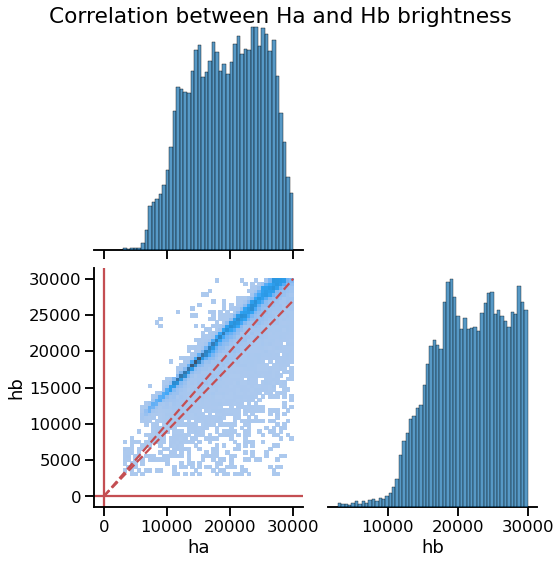

In [36]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 0.9*imax], "--", color="r")
g.fig.suptitle("Correlation between Ha and Hb brightness");

So, the slope is not unity, meaning the extinction is not zero.  But the intercept os not zero either. Clearly, we must fix that

In [41]:
x = imha.data
y = R0*imhb.data - 5500
imax = 30000
m = (x < imax) & (y < imax)
m = m & ~imha.mask & ~imhb.mask
df = pd.DataFrame(
    {
        "ha": x[m],
        "hb": y[m],
    }
)

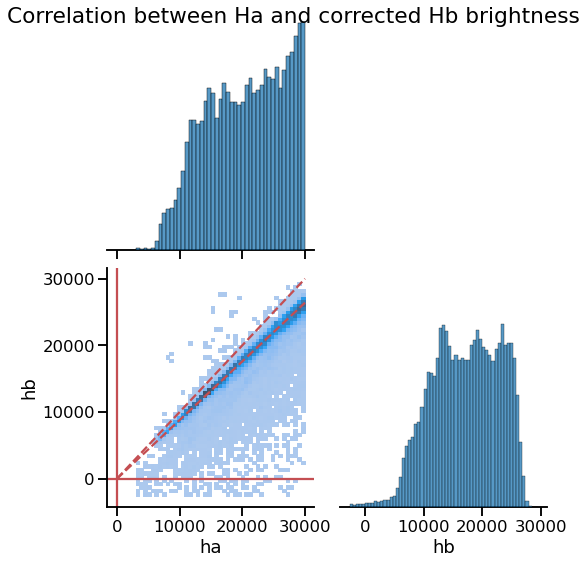

In [43]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 0.88*imax], "--", color="r")
g.fig.suptitle("Correlation between Ha and corrected Hb brightness");

That looks way better.  Expand out to brighter pixels:

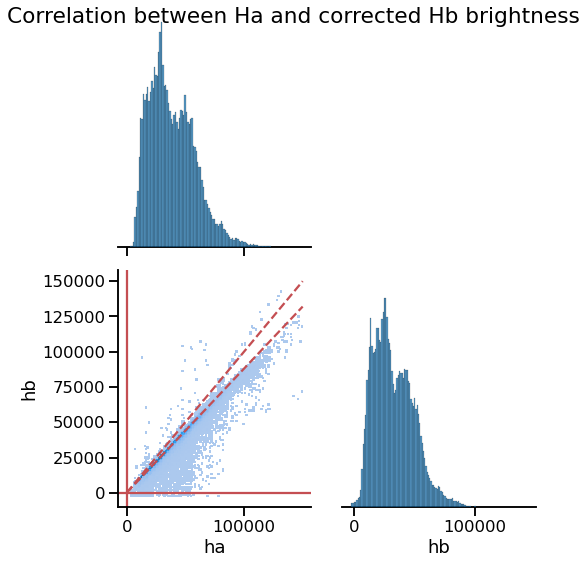

In [45]:
imax = 150000
m = (x < imax) & (y < imax)
m = m & ~imha.mask & ~imhb.mask
df = pd.DataFrame(
    {
        "ha": x[m],
        "hb": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 0.88*imax], "--", color="r")
g.fig.suptitle("Correlation between Ha and corrected Hb brightness");

Now fix the Hb image and try again:

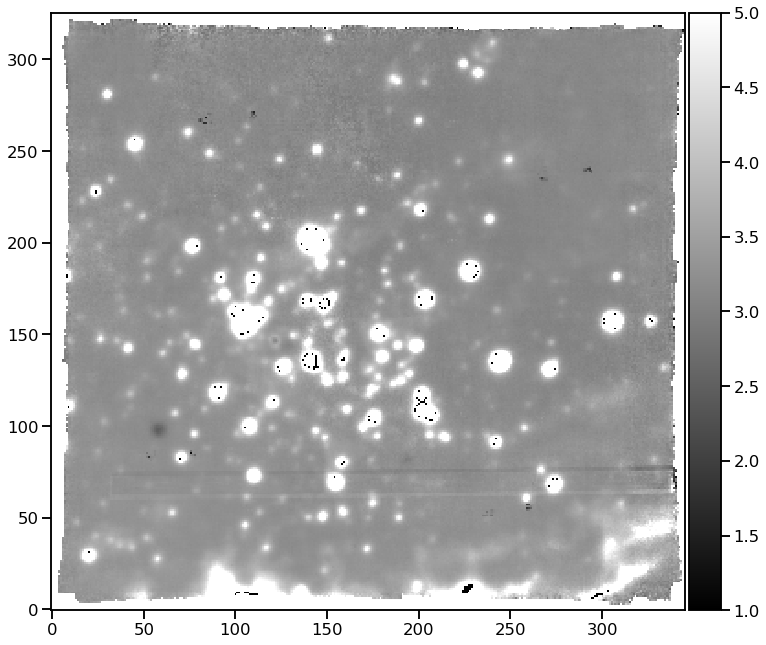

In [46]:
hbfix = 5500 / R0
fig, ax = plt.subplots(figsize=(12, 12))
(imha/(imhb - hbfix)).plot(vmin=1.0, vmax=5.0, cmap="gray", colorbar="v")

That is on the same brightness map as before, and it now completely eliminates the spurious structure associate with surface brightness – hurray!

Now, plot on a better scale

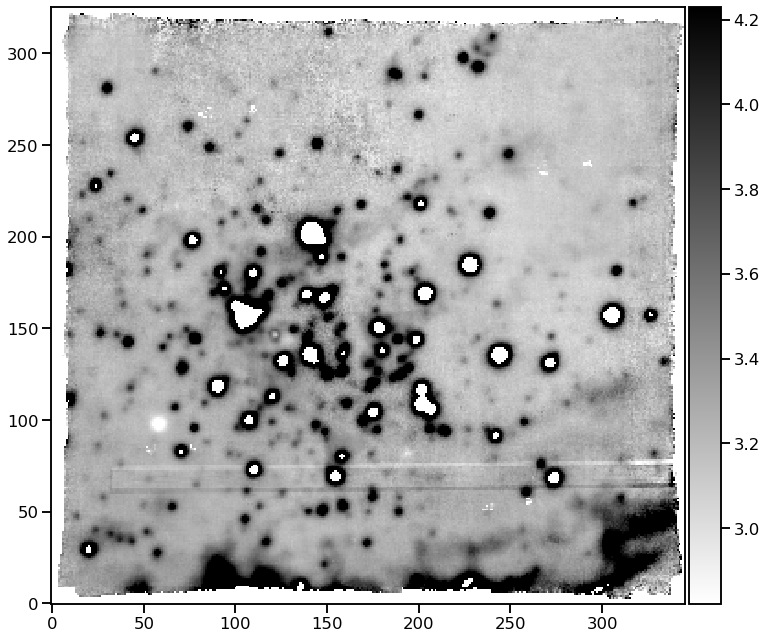

In [52]:
fig, ax = plt.subplots(figsize=(12, 12))
(imha/(imhb - hbfix)).plot(
    vmin=R0, vmax=1.5*R0, 
    scale="linear",
    cmap="gray_r", colorbar="v",
);

We can see some very high extinction at in the S filaments.  And some small increase in extinction in the main diagonal filament.  This is probably limited having foreground emission to some extent.

In [55]:
pn.RedCorr().getLaws()

dict_keys(['No correction', 'CCM89', 'CCM89 Bal07', 'CCM89 oD94', 'S79 H83 CCM89', 'K76', 'SM79 Gal', 'G03 LMC', 'MCC99 FM90 LMC', 'F99-like', 'F99', 'F88 F99 LMC'])